## DISCOVERY EDA CLUSTERIZAR DATA
- El objetivo es poder identificar qué series son similares entre sí. Se probó utilizar correlaciones pero al ser 30k de datos el código se demora demasiado (y generaría una matriz de 30k x 30k). así que se prefiere utilizar un enfoque de clustering, sampleo para poder agrupar las series de forma más rápida

In [1]:
import os
# set path root of repo
actual_path = os.path.abspath(os.getcwd())
list_root_path = actual_path.split('/')[:-1]
root_path = '/'.join(list_root_path)
os.chdir(root_path)
print('root path: ', root_path)

root path:  /Users/joseortega/Documents/GitHub/forecasting-m5-dataset


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis, variation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

### 1. Read raw files

In [33]:
folder_data_raw_dtype = 'data/data_input_dtype/'

df_calender = pd.read_pickle(folder_data_raw_dtype + 'calendar.pkl')
df_prices = pd.read_pickle(folder_data_raw_dtype + 'sell_prices.pkl')
df_sales = pd.read_pickle(folder_data_raw_dtype + 'sales_train_evaluation.pkl')
df_sample_output = pd.read_pickle(folder_data_raw_dtype + 'sample_submission.pkl')

In [4]:
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,2.0,6.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0


In [5]:
df_sales.shape

(30490, 1947)

### 2. Eliminar columnas no utilizadas para tener dataframe solo con las series

In [6]:
# eliminar columnas no utilizadas
df_sales = df_sales.drop(columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
df_sales = df_sales.set_index('id')

# transformar todas las columnas que están en formato string a float
# data[data.select_dtypes(include=['object']).columns] = data.select_dtypes(include=['object']).apply(pd.to_numeric, errors='coerce')

In [7]:
# EL DATAFRAME ESTÁ ORDENADO PARA QUE CADA FILA (CADA OBSERVACIÓN) REPRESENTE UNA SERIE DE TIEMPO Y PODER HACER CLUSTERING
df_sales.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0
HOBBIES_1_002_CA_1_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
HOBBIES_1_003_CA_1_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0


### 3. Calcular estadísticos para cada serie
Calcular media, desviacion estandar, min, max, etc

In [8]:
# crear df donde guardar estadísticos
estadisticos_series = pd.DataFrame(df_sales.index)

In [9]:
# calcular estadisticos básicos
estadisticos_series['mean'] = df_sales.mean(axis = 1).values
estadisticos_series['std'] = df_sales.std(axis = 1).values
estadisticos_series['min'] = df_sales.min(axis = 1).values
estadisticos_series['max'] = df_sales.max(axis = 1).values

# calcular estadisticos skew, curtosis, coeficiente variacion (sicpy funciones necesitan data traspuesta)
estadisticos_series['skew'] = skew(df_sales.T)
estadisticos_series['kurtosis'] = kurtosis(df_sales.T)
estadisticos_series['variation'] = variation(df_sales.T)

# hay varias veces que no hay ventas. valor cero. calcular estadísticos sin considerar esas series
df_dales_zero_null = df_sales.replace(0, np.nan)

estadisticos_series['mean_no_zeros'] = df_dales_zero_null.mean(axis = 1).values
estadisticos_series['std_no_zeros'] = df_dales_zero_null.std(axis = 1).values
estadisticos_series['min_no_zeros'] = df_dales_zero_null.min(axis = 1).values

# setear indice
estadisticos_series = estadisticos_series.set_index('id')

In [10]:
estadisticos_series.head(3)

,mean,std,min,max,skew,kurtosis,variation,mean_no_zeros,std_no_zeros,min_no_zeros
id,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,0.326121,0.708043,0.0,5.0,2.672921,8.368169,2.170549,1.451835,0.773094,1.0
HOBBIES_1_002_CA_1_evaluation,0.257599,0.568590,0.0,5.0,2.894973,11.675778,2.206697,1.225490,0.593276,1.0
HOBBIES_1_003_CA_1_evaluation,0.159196,0.501445,0.0,6.0,4.278133,24.989683,3.149041,1.349345,0.725635,1.0


### 4. Normalizar los datos

In [11]:
# escalar los datos
scaler_data = MinMaxScaler() # StandardScaler()
df_sales_scaled = scaler_data.fit_transform(df_sales)

# escalar los estadisticos
scaler_estadisticos = MinMaxScaler() # StandardScaler()
estadisticos_series_scaled = scaler_estadisticos.fit_transform(estadisticos_series)

In [12]:
df_sales_scaled.shape

(30490, 1941)

In [13]:
estadisticos_series_scaled.shape

(30490, 10)

### 5. Reducir dimensionalidad de las series. Evitar maldicion de dimensionalidad al hacer clustering
Cada serie tiene 1900 observaciones. Entonces cada observación tiene 1900 features lo cual es mucho

In [14]:
def calculate_pca(df, threshold):
    """
    Dado un dataframe con la data lista para usar (ya escalada) se procede a calcular múltiples reducciones de dimensionalidad
    con diferente cantidad de componentes para elegir la cantidad óptima
    
    Args
        df (DataFrame): Dataframe de la forma (series, timestamp) donde cada fila es una serie.
        threshold (float): threshold de variabilidad explicada por PCA para decidir cantidad de dimensiones de PCA

    Return
        output_dicc_pca (diccionario): Diccionario donde se guardan resultados de entrenamiento PCA históricos
        pca (model): output con el modelo entrenado que cumple condición de variabilidad explicada
    """

    # output del entrenamiento
    output_dicc_pca = {}
    
    # definir cantidad máxima de componentes a probar. en base a la cantidad de features en los datos (reducir mínimo a un 10% las fechas)
    max_n_components = int(df.shape[1] / 10)
    
    # calcular PCA para el rango de componentes definidos. terminar ejecución si se cumple la condición de variabilidad explicada
    for n_components in range(5, max_n_components):
        
        if n_components % 10 == 0:
            print('pca con dimensión: ', n_components)
        
        # definir modelo y reducir componentes
        pca = PCA(n_components = n_components)
        df_pca = pca.fit_transform(df)
        
        # obtener la varianza acumulada y el índice de la número de componente que supera el threshold de varianza explicada
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        c_over_threshold = np.argmax(cumulative_variance >= threshold) + 1
        
        # guardar en un diccionario. n_componentes, array varianza acumulada, índice de componente que supera el threshold de varianza
        aux_one_output_dicc_pca = {}
        aux_one_output_dicc_pca['n_components'] = n_components
        aux_one_output_dicc_pca['cumulative_variance'] = cumulative_variance
        aux_one_output_dicc_pca['c_over_threshold'] = c_over_threshold # index componente que supera criterio variabilidad
        output_dicc_pca[n_components] = aux_one_output_dicc_pca
    
        # en PCA se puede aumentar la cantidad de dimensiones pero la varianza explicada de las dimensiones intermedias se debería mantener cercana 
        # si se cumple la condición del threshold terminar el for
        if aux_one_output_dicc_pca['c_over_threshold'] != 1:
            print('Cantidad de dimensiones PCA: ', n_components)
            print('Cantidad de dimensiones que cumplen criterio variabilidad explicada: ', c_over_threshold)
            break
    
    return output_dicc_pca, pca

In [15]:
# obtener mejor modelo PCA
output_dicc_pca, pca_model = calculate_pca(df = df_sales_scaled, 
                                           threshold = 0.7)

pca con dimensión:  10
Cantidad de dimensiones PCA:  18
Cantidad de dimensiones que cumplen criterio variabilidad explicada:  18


In [16]:
# obtener datos reducido dimensionalidad
df_sales_scaled_pca = pca_model.transform(df_sales_scaled)

In [17]:
# reducir dimensionalidad datos reducido dimensionalidad
scaler_data_pca = MinMaxScaler() # StandardScaler()
df_sales_scaled_pca_scaled = scaler_data_pca.fit_transform(df_sales_scaled_pca)

In [18]:
df_sales_scaled_pca_scaled.max(axis = 0)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9999999 , 1.        , 1.        ,
       1.        , 0.99999994, 1.        ], dtype=float32)

### 6.a Entrenar kmeans con la data sin reducir dimensionalidad

In [19]:
def calculate_kmeans(df, max_cluster):
    """
    Dado un dataframe de entrada, clusterizar con kmeans. 
    Se hacen pruebas con diferentes cantidad de clusters (de 2 a 10). Se retorna el mejor modelo obtenido evaluado por sil score
    
    Args:
        df (DataFrame): Dataframe con los datos YA escalados. Se que usará para calcular los clusters
        max_cluster (integer): Cantidad máxima de clusters a probar
    Return
        best_n_cluster (integer): mejor cantidad de clusters
        best_sil_score (float): mejor métrica
        best_ch_score (float): mejor métrica
        best_model (model): Modelo guardado como el mejor. Dado el valor de sil_score
    """

    # inicializar métricas
    best_sil_score = -1
    best_ch_score = 0
    best_n_cluster = 0
    best_model = None

    # inicializar para guardar inercia
    inertia = [] 

    # clusterizar data y evaluar modelo. retornar el que calcula la mejor métrica
    for n_cluster in range(2, max_cluster):
        print(n_cluster)

        # definir modelo y entrenar
        kmeans = KMeans(n_clusters = n_cluster, random_state=0, n_init="auto")
        kmeans.fit(df)
        labels = kmeans.labels_
        
        # obtener silhouette_score. Esta métrica se demora. Se podria usar ch-score para evaluar qué cluster tiene la mejor
        # métrica y para ese cluster seleccionado calcular el sil_score que tiene valores interpretables
        sil_score = silhouette_score(df, labels)
        
        # Calcular el Calinski-Harabasz Index. Sigue al sil_score, un sil_score mayor también es ch_mayor. Se demora muy poco
        # en calcular. Pero su valor no es interpretable. No tiene cota superior. Entre más alto mejor
        ch_score = calinski_harabasz_score(df, labels)

        # obtener inecia y guardarla
        inercia_cluster = kmeans.inertia_
        inertia.append(inercia_cluster)
        
        # print
        print('cantidad de clusters: ', n_cluster)
        print('sil_score: ', sil_score)
        print('ch_score: ', ch_score)
        
        # si sil_score es mejor que la mejor métrica guarda. se reemplaza. Conservar el modelo que mejor clusterize
        if sil_score >= best_sil_score:
            print('se actualizan los mejores resultados')
            best_sil_score = sil_score
            best_ch_score = ch_score
            best_model = kmeans
            best_n_cluster = n_cluster

    return inertia, best_n_cluster, best_sil_score, best_ch_score, best_model

In [20]:
# definir cantidad máxima de clusters 
param_max_cluster_inter = 16

In [21]:
# datos usados para esta prueba
df_sales_scaled.shape

(30490, 1941)

In [22]:
# entrenar mejor kmeans
inercia_cluster_a, best_n_cluster_a, best_sil_score_a, best_ch_score_a, best_model_a = calculate_kmeans(df = df_sales_scaled,
                                                                                                        max_cluster = param_max_cluster_inter
                                                                                                       )

2
cantidad de clusters:  2
sil_score:  0.85751885
ch_score:  10742.817994975729
se actualizan los mejores resultados
3
cantidad de clusters:  3
sil_score:  0.7653184
ch_score:  9197.926140234249
4
cantidad de clusters:  4
sil_score:  0.65142596
ch_score:  7765.6940197854265
5
cantidad de clusters:  5
sil_score:  0.5189279
ch_score:  6460.2894861173445
6
cantidad de clusters:  6
sil_score:  0.48973554
ch_score:  5446.153499748978
7
cantidad de clusters:  7
sil_score:  0.40739876
ch_score:  4765.809885069409
8
cantidad de clusters:  8
sil_score:  0.41975594
ch_score:  4371.689029213159
9
cantidad de clusters:  9
sil_score:  0.40145054
ch_score:  3948.206772484786
10
cantidad de clusters:  10
sil_score:  0.32434055
ch_score:  3607.42937380315
11
cantidad de clusters:  11
sil_score:  0.32438406
ch_score:  3332.0014426078474
12
cantidad de clusters:  12
sil_score:  0.32439676
ch_score:  3081.5012118850805
13
cantidad de clusters:  13
sil_score:  0.2636451
ch_score:  2883.7691768817544
14
ca

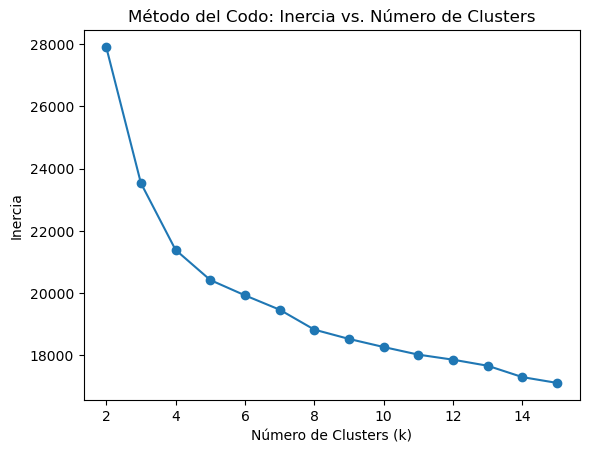

In [23]:
# plotear inercia
array_index_clusters = np.arange(2, param_max_cluster_inter)
plt.plot(array_index_clusters, inercia_cluster_a, marker='o')
plt.title("Método del Codo: Inercia vs. Número de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.show()

### 6.b Entrenar kmeans con la data reducida dimensionalidad

In [24]:
# datos usados para esta prueba
df_sales_scaled_pca_scaled.shape

(30490, 18)

In [25]:
# entrenar mejor kmeans
inercia_cluster_b, best_n_cluster_b, best_sil_score_b, best_ch_score_b, best_model_b = calculate_kmeans(df = df_sales_scaled_pca_scaled,
                                                                                                        max_cluster = param_max_cluster_inter
                                                                                                       )

2
cantidad de clusters:  2
sil_score:  0.8708321
ch_score:  2354.1449920753726
se actualizan los mejores resultados
3
cantidad de clusters:  3
sil_score:  0.83268464
ch_score:  2054.717538331416
4
cantidad de clusters:  4
sil_score:  0.761674
ch_score:  1909.933248671125
5
cantidad de clusters:  5
sil_score:  0.7695245
ch_score:  1669.6226470989538
6
cantidad de clusters:  6
sil_score:  0.7605339
ch_score:  1566.2747150478142
7
cantidad de clusters:  7
sil_score:  0.7619696
ch_score:  1534.6356301109909
8
cantidad de clusters:  8
sil_score:  0.7414561
ch_score:  1462.8433095993062
9
cantidad de clusters:  9
sil_score:  0.7370349
ch_score:  1423.175717744054
10
cantidad de clusters:  10
sil_score:  0.6999527
ch_score:  1416.209990540556
11
cantidad de clusters:  11
sil_score:  0.6848544
ch_score:  1385.4215159449993
12
cantidad de clusters:  12
sil_score:  0.66854817
ch_score:  1335.0136270016
13
cantidad de clusters:  13
sil_score:  0.63809055
ch_score:  1284.8795782948794
14
cantidad 

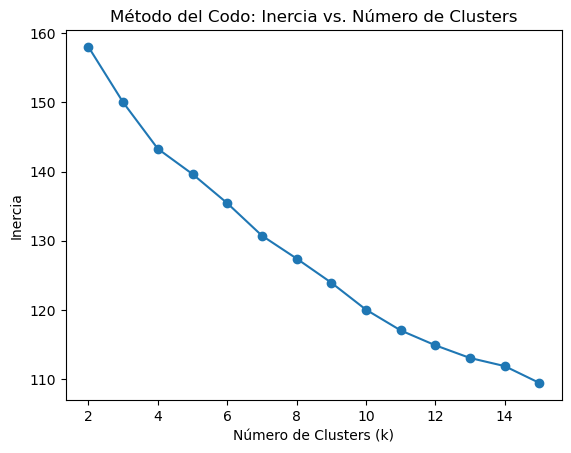

In [26]:
# plotear inercia
array_index_clusters = np.arange(2, param_max_cluster_inter)
plt.plot(array_index_clusters, inercia_cluster_b, marker='o')
plt.title("Método del Codo: Inercia vs. Número de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.show()

### 6.c Entrenar kmeans con la data con indicadores técnicos

In [27]:
# datos usados para esta prueba
estadisticos_series_scaled.shape

(30490, 10)

In [28]:
# entrenar mejor kmeans
inercia_cluster_c, best_n_cluster_c, best_sil_score_c, best_ch_score_c, best_model_c = calculate_kmeans(df = estadisticos_series_scaled,
                                                                                                        max_cluster = param_max_cluster_inter
                                                                                                       )

2
cantidad de clusters:  2
sil_score:  0.5132054
ch_score:  17599.17971889765
se actualizan los mejores resultados
3
cantidad de clusters:  3
sil_score:  0.4156925
ch_score:  14111.151050809363
4
cantidad de clusters:  4
sil_score:  0.4699562
ch_score:  16130.237626406277
5
cantidad de clusters:  5
sil_score:  0.4769358
ch_score:  15174.67833538051
6
cantidad de clusters:  6
sil_score:  0.44485664
ch_score:  15881.007925928516
7
cantidad de clusters:  7
sil_score:  0.4021118
ch_score:  15892.504597187957
8
cantidad de clusters:  8
sil_score:  0.3994698
ch_score:  15276.780765748184
9
cantidad de clusters:  9
sil_score:  0.400579
ch_score:  14337.498854823001
10
cantidad de clusters:  10
sil_score:  0.40499446
ch_score:  14367.965188179105
11
cantidad de clusters:  11
sil_score:  0.40126
ch_score:  14195.449041823746
12
cantidad de clusters:  12
sil_score:  0.39288458
ch_score:  13797.534202430177
13
cantidad de clusters:  13
sil_score:  0.3728683
ch_score:  14252.740789508476
14
cantid

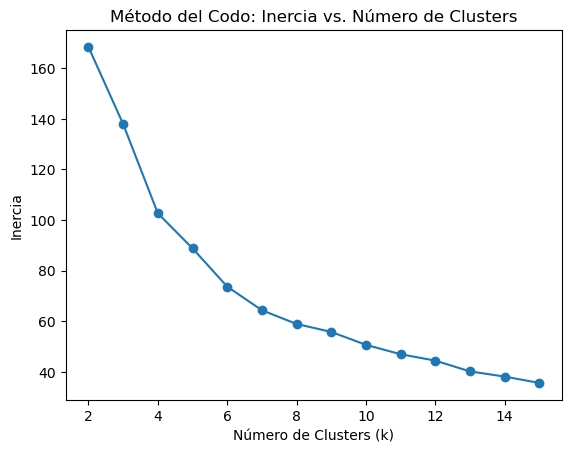

In [29]:
# plotear inercia
array_index_clusters = np.arange(2, param_max_cluster_inter)
plt.plot(array_index_clusters, inercia_cluster_c, marker='o')
plt.title("Método del Codo: Inercia vs. Número de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.show()

### 6.d Entrenar kmeans con la data reducida de dimensionalidad y además agregar indicadores técnicos series

In [30]:
# unir data pca reducida + data estadisticos
df_combined = pd.concat([pd.DataFrame(df_sales_scaled_pca_scaled), 
                         pd.DataFrame(estadisticos_series_scaled)
                        ], axis=1)
df_combined.shape

(30490, 28)

In [31]:
# entrenar mejor kmeans
inercia_cluster_d, best_n_cluster_d, best_sil_score_d, best_ch_score_d, best_model_d = calculate_kmeans(df = df_combined,
                                                                                                        max_cluster = param_max_cluster_inter
                                                                                                       )

2
cantidad de clusters:  2
sil_score:  0.64016664
ch_score:  4359.750024568706
se actualizan los mejores resultados
3
cantidad de clusters:  3
sil_score:  0.44654548
ch_score:  7701.644006615062
4
cantidad de clusters:  4
sil_score:  0.33538964
ch_score:  6807.26059395758
5
cantidad de clusters:  5
sil_score:  0.36604473
ch_score:  6098.683953694328
6
cantidad de clusters:  6
sil_score:  0.30696982
ch_score:  5616.13824164531
7
cantidad de clusters:  7
sil_score:  0.30751377
ch_score:  4994.8383294225005
8
cantidad de clusters:  8
sil_score:  0.2561823
ch_score:  4794.2408278750845
9
cantidad de clusters:  9
sil_score:  0.26999825
ch_score:  4412.9286475814
10
cantidad de clusters:  10
sil_score:  0.26611316
ch_score:  4133.21106339607
11
cantidad de clusters:  11
sil_score:  0.266568
ch_score:  3875.1734270008733
12
cantidad de clusters:  12
sil_score:  0.24563241
ch_score:  3660.1394562472833
13
cantidad de clusters:  13
sil_score:  0.24793199
ch_score:  3488.425260203174
14
cantidad

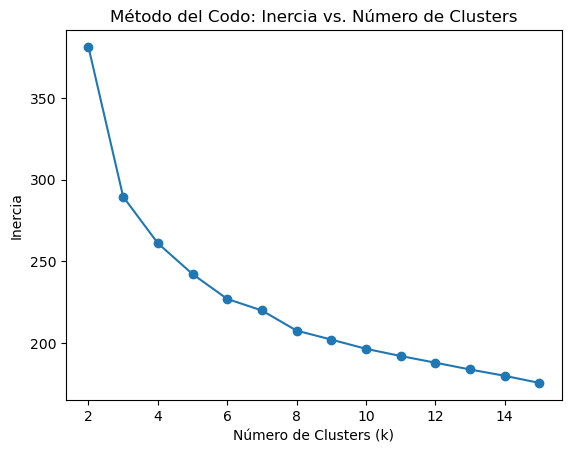

In [32]:
# plotear inercia
array_index_clusters = np.arange(2, param_max_cluster_inter)
plt.plot(array_index_clusters, inercia_cluster_d, marker='o')
plt.title("Método del Codo: Inercia vs. Número de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.show()